## Introduction

Here, we will be covering how to use xbatcher with Keras/Tensorflow convolutional neural network (CNN) models. 

This notebook replicates the work of [Sinha and Abernathey, 2021](https://www.frontiersin.org/article/10.3389/fmars.2021.672477), where the goal is to use a CNN to learn ocean surface currents (which are usually inferred diagnostically or modelled) from variables that can be observed directly, like sea surface temperature (SST) or wind stress. 

Can we learn to predict ocean currents with just one snapshot of data?

To start, let's import some libraries we'll need. The important libraries here are `numpy`, `xarray`, `xbatcher` and `tensorflow`, while most of the others aren't strictly necessary.

In [1]:
import numpy as np
import xarray as xr

from intake import open_catalog
from dataclasses import dataclass
from typing import Iterable

In [2]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [3]:
import tensorflow as tf

2023-02-03 21:55:28.349839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import xbatcher as xb

In [5]:
#import itertools

## Designing Scenarios

We want to experiment with different neural network models by providing different inputs, and perhaps by playing with whether or not we run them through a convolutional layer. There are a lot of possibilities here, and if we approach it haphazardly, we'll end up with a mess of scattered experiments and results mixed in with other code. 

Instead, we can be more systematic about it. We know we want to define an individual scenario once, and then have it stay constant through the workflow. This way, there will be no compllexities later on about whether we're refering to the right dataset, etc. With that in mind, we should use a `dataclass`. We want something minimal here, just enough to store the names of variables we're interested in. 

What is the structure of each experiment? We want some input variables to be run through a 2D convolutional layer, while some other inputs will be passed through directly to the dense part of the neural network. Both of these can be lists of strings, so we define `conv_var` and `input_var` as `Iterable[str]`.

Likewise, we have more than one target, so we define the `target` item as `Iterable[str]` as well. Outside of the `Scenario` dataclass, we define `target` as a list: `['U', 'V']`. Since we're only interested in learning the currents, this won't change.

Finally, we need to name each scenario something distinct, so when we create data subsets for training, testing, and prediction, we can recover them later.

In [6]:
@dataclass
class Scenario:
    conv_var: Iterable[str]
    input_var: Iterable[str]
    target: Iterable[str]
    name: str

In [7]:
target = ['U', 'V']

In [8]:
sc1 = Scenario(['SSH'],             ['TAUX', 'TAUY'], target, name = "derp")
sc5 = Scenario(['SSH', 'SST'], ['X', 'TAUX', 'TAUY'], target, name = "herp")

## Data and Preprocessing

For our dataset, we will be using ocean data from a high-resolution CESM POP model. 

We have some necessary I/O routines, but they aren't central to our problem, aside from the addtion of the new variables `X`, `Y`, `Z`, `dx` and `dy`, which represent Euclidean positions and distances between grid points.

You can have a look in the notebook below if you're curious about it.

In [9]:
%run ./surface_currents_prep.ipynb

From this notebook, we get a few new functions.

  * `prepare_data` takes a scenario, as well as the time slices for training, testing, and prediction we are interested in, and the time slice we'll use for the NaN mask. It adds the new grid variables, and then stores each slice in a new zarr store that we can access later. This speeds up future I/O, which is helpful when modifying the model. Each scenario is stored separately.
  * `load_training_data` loads the training data created for the scenario passed to it.
  * `load_test_data` loads the testing data created for the scenario passed to it.
  * `load_predict_data` loads the prediction input data created for the scenario passed to it.
  
You can comment out `prepare_data` after you've run it once, it will save time if you rerun the whole notebook again.

In [ ]:
prepare_data(sc5, 200, 1000, 1000, 200)

Next, we'll load our training data and pick out the part we want to train with. 

In [10]:
ds_training = load_training_data(sc5)
ds_training

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600)
Coordinates: (12/52)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
    time                object ...
    vonkar              float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    SSH                 (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    SST                 (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TAUX                (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TAUY                (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    U                   (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    V                   (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    X                   (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    mask                (nlat, nlon) bool dask.array<chunksize=(600, 900), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    calendar:      All years have exactly  365 days.
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    contents:      Diagnostic and Prognostic Variables
    history:       none
    nsteps_total:  13088337
    revision:      $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy@ucar.edu $
    source:        CCSM POP2, the CCSM Ocean Component
    start_time:    This dataset was created on 2013-03-09 at 12:25:55.7
    tavg_sum:      86399.99999999962
    title:         hybrid_v5_rel04_BC5_ne120_t12_pop62

Looking inside `ds_training`, we see only the variables we would expect from `sc5`. 

In [11]:
ds_training = ds_training.isel(nlon=list(range(250,550)), nlat=list(range(1350,1650)))

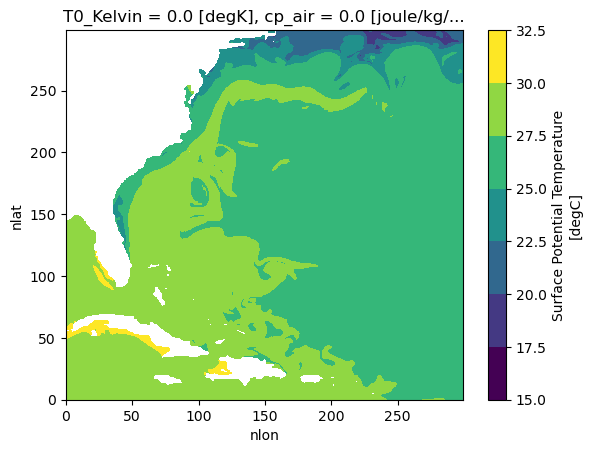

In [12]:
xr.plot.contourf(ds_training['SST'])

In [13]:

# plt.figure(figsize=(15,15))
# plt.contourf(ds_training['SST'])
# plt.show()

## Training a Model with xbatcher

We have a model architecuture we're happy with already defined, so for this tutorial, we'll focus on how to use xbatcher to generate training sets for the model. From the notebook below, we recieve:
  * `get_model()` Creates a mixed neural network based on some parameters. The architecture is intentionally a little arbitrary in terms of the depth of the dense part of the network, the depth of the convolutional part of the network, and the convolution kernel size. Returns a compiled Keras model.
  * `LossHistory()` Only needed here because it has to be passed to `model.fit()`.
  * `train()` We will walk through this routine below.

Have a look inside for more details!

In [14]:
%run ./surface_currents_model.ipynb

Now the fun part: we define the `train` function to deal with high-level aspects of training the model, which means this is a good place to use xbatcher. Let's walk through it...

The arguments to `train` are
  * `ds: xr.DataSet` The dataset you want to work with.
  * `sc: Scenario` The scenario you want to work with.
  * `conv_dims: List[int]` This is the shape of the stencil that will be passed to the first convolutional layer. We are only interested in 2D convolutions here, so it will need to be a list of two integers. Note that this is distinct from the convolutional kernel.
  * `nfilters: int` How many filters do we want to map the first convolution layer to?
  * `conv_kernels: List[int]` Each entry denotes the convolution kernel of a new convolution layer. `train` works best for odd-numbered convolution kernels.
  * `dense_layers: int` The number of dense layers in the model.
  
For this example, we only use one convolution layer, which makes some things simpler. Feel free to experiment with these parameters to use different data sets and create new CNN models.

In [15]:
ds = ds_training.fillna(0)
sc = sc5
conv_dims = [3,3]
nfilters = 80
conv_kernels = [3]
dense_layers = 3

We'll need some info about how to rectify the output of the convolution layers with raw input from other variables (see the surface_currents_model.ipynb notebook for more info). Based on the convolution kernel, we know how the output of a convolution layer will be shaped compared to the input: a halo of a certain size will be removed from the edges. For odd convolution kernels, the halo thickness is always $\frac{n - 1}{2}$ where $n$ is the kernel.

In [16]:
halo_size = int((np.sum(conv_kernels) - len(conv_kernels))/2)

Since we are trying to learn from a single 2D snapshot, it makes sense to iterate in both latitude and longitude. What we want are individual samples of the size given by `conv_dims`, but batched in a way that we can pass the correct number of samples to the model as a single tensor. So, `input_dims` will contain entries for both `nlon` and `nlat`. To take full advantage of the available data, we can add an overlap to make sure halo points are fully included in the neighboring samples.

In [17]:
nlons, nlats = conv_dims

bgen = xb.BatchGenerator(
    ds,
    {'nlon':nlons,       'nlat':nlats},
    {'nlon':2*halo_size, 'nlat':2*halo_size},
    concat_input_dims=True
)

We need a subsetting stencil (`sub`) to compensate for the fact that a halo is removed by each convolution layer. This means that the input_var variables will be the wrong size at the concat layer unless we strip the halo from them.

In [18]:
sub = {'nlon_input':range(halo_size,nlons-halo_size),
       'nlat_input':range(halo_size,nlats-halo_size)}

Here, we generate our model and our history callback.

In [19]:
model = get_model(halo_size, ds, sc, conv_dims, nfilters, conv_kernels, dense_layers)
history = LossHistory()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 3, 2)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 1, 1, 80)     1520        ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 1, 3)]    0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 1, 1, 83)     0           ['conv2d[0][0]',                 
                                                                  'input_2[0][0]']            

2023-02-03 21:55:48.475217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/nvidia/lib64
2023-02-03 21:55:48.475260: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)


And now, we can construct our training loop. Most use cases of the `xb.BatchGenerator` will take the form of a for-loop with the construct `for batch in bgen`.

Once we have a batch, we still have some things to do before we can pass the data to the model.

So when we look at the contents of each batch, we see

In [20]:
for batch in bgen:
    batch
    break

KeyboardInterrupt: 

...but our model expects tensors where the different variables are stacked in a new dimension we will call `var`. 

Looking at `model.fit()`, we have two separate inputs because of the distinction between convolved inputs and raw inputs. Therefore, the model expects these inputs to be given as a list of the two. The training target is relatively straightforward. On the next line, we have a couple of parameters we can experiment with. The important thing to note is the `batch_size` parameter; you may need to check that the sample dimension is compatible with the dimensions that `xb.BatchGenerator` returned. And finally, we pass our history class as a callback so we can see how the model training is progressing.

In [ ]:
for batch in bgen:

    batch_conv   = [batch[x] for x in sc.conv_var]
    batch_input  = [batch[x][sub] for x in sc.input_var]
    batch_target = [batch[x][sub] for x in sc.target]
    batch_conv   = xr.merge(batch_conv).to_array('var').transpose(...,'var')
    batch_input  = xr.merge(batch_input).to_array('var').transpose(...,'var')
    batch_target = xr.merge(batch_target).to_array('var').transpose(...,'var')

    clear_output(wait=True)
    model.fit([batch_conv, batch_input],
              batch_target,
              batch_size=32, epochs=4, verbose=0,
              callbacks=[history])

In [ ]:
model.save('models/'+ sc.name)
np.savez('models/history_'+sc.name, losses=history.mae, mse=history.mse, accuracy=history.accuracy)

## Training Function

In [ ]:
#train(ds_training.fillna(0), sc5)

## Testing the Model

In [ ]:
ds_test = load_test_data(sc5)
ds_test

In [ ]:
def test(ds, sc):
    model = tf.keras.models.load_model('models/'+ sc.name)
    
    vanilla = cat_vars(ds, sc, get_vanilla)
    target  = cat_vars(ds, sc, get_target)
    
    stencil_2D = None
    stencil_3D = None
    if(sc.stencil_2D):
        stencil_2D = cat_vars(ds, sc, get_stencil_2D)
    if(sc.stencil_3D):
        stencil_3D = cat_vars(ds, sc, get_stencil_3D)
    
    gc.collect()
    
    model.evaluate([batch_input, batch_conv], batch_target)
    pass

In [ ]:
test(ds_test.fillna(0), sc5)

## Making Predictions

In [ ]:
ds_predict = load_predict_data(sc5)
ds_predict

In [ ]:
def predict(ds, sc):
    model = tf.keras.models.load_model('models/'+ sc.name)
    
    vanilla = cat_vars(ds, sc, get_vanilla)
    
    stencil_2D = None
    stencil_3D = None
    if(sc.stencil_2D):
        stencil_2D = cat_vars(ds, sc, get_stencil_2D)
    if(sc.stencil_3D):
        stencil_3D = cat_vars(ds, sc, get_stencil_3D)

    gc.collect()
    
    target = model.predict(filter_none([stencil_2D, stencil_3D, vanilla]))
    return target

In [ ]:
targets_pr = predict(ds_predict.fillna(0), sc5)

Now, let's take a look at the predicted surface currents and see how the model did:

In [ ]:
U = ds_predict['U'].values.reshape(2400, 3600)
V = ds_predict['V'].values.reshape(2400, 3600)

In [6]:
U_pred = targets_pr[:,0].reshape(2400, 3600)
V_pred = targets_pr[:,1].reshape(2400, 3600)

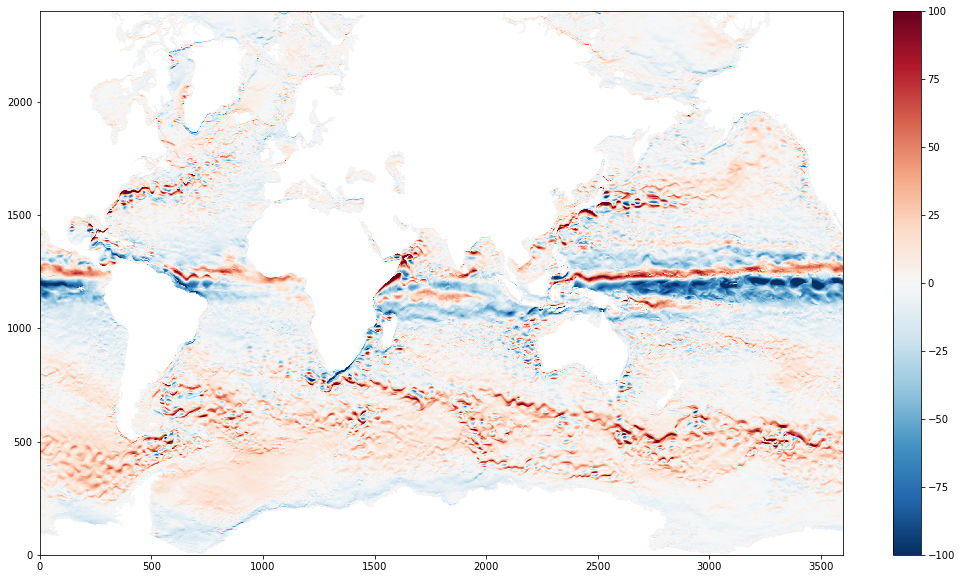

In [5]:
plt.figure(figsize=(18, 10))
plt.pcolormesh(U, cmap='RdBu_r')
plt.clim([-100, 100])
plt.colorbar()

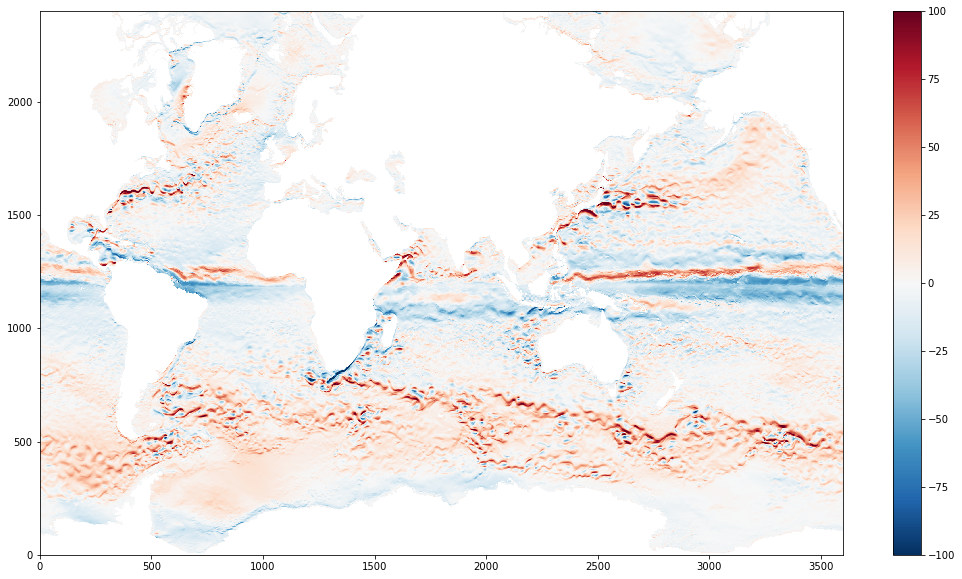

In [7]:
plt.figure(figsize=(18, 10))
plt.pcolormesh(U_pred, cmap='RdBu_r')
plt.clim([-100, 100])
plt.colorbar()

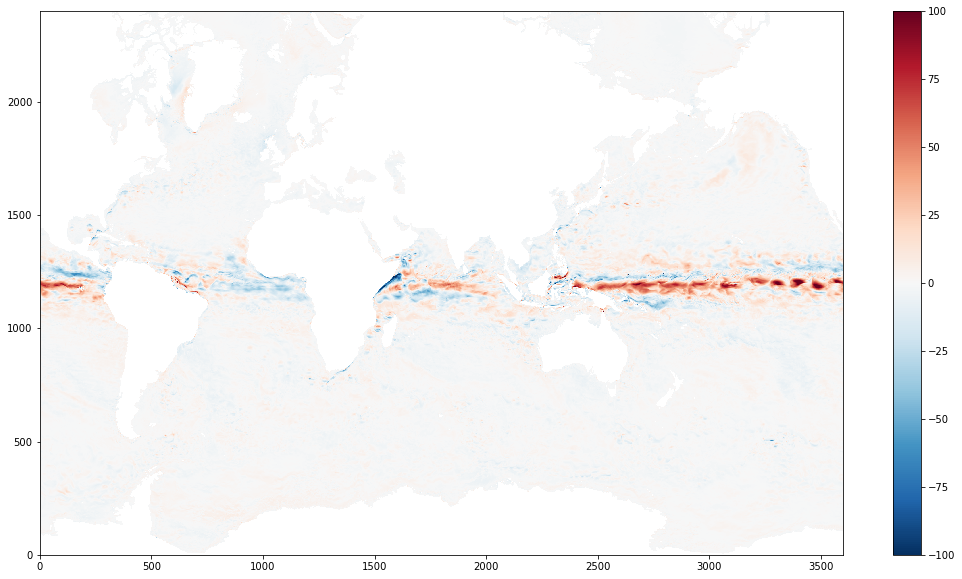

In [8]:

plt.figure(figsize=(18, 10))
plt.pcolormesh(U_pred - U, cmap='RdBu_r')
plt.clim([-100, 100])
plt.colorbar()